In [1]:
#import packages and formatting statements
import numpy as np
import matplotlib as mpl
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import astropy.io.fits as pyfits
from astropy.table import Table, join, Column
from astropy.wcs import WCS
from astropy.io import ascii
import os

import sys
sys.path.append('./Python')
from CheckInImage import check_in_image

plt.rc('text',usetex=False)
fontsize=20
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

ext = "HA_FLUX_CORR"

In [2]:
# Compile galaxy and OSC objects
# full catalog header: Name,Type,Host,RA hms,Dec dms,RA dds,Dec dds,DiscDate

DataFile = '../Data/0.MUSEdata.csv'
Data = Table.read(DataFile, format='csv') 
galaxies, dists =  Data["Galaxy"], Data["Distance"]
maps_1kpc, gal_ra, gal_dec, gal_pa = Data["maps_1kpc"], Data["Gal_ra"], Data["Gal_dec"], Data["Pos_ang"]
MUSE_res, maps_150, maps_HII, maps_irac,incls = Data["MUSE_nat_res"], Data["maps_150"], Data["maps_HII"], Data["maps_irac"], Data["Incl"]
maps_nat,maps_CO21,maps_eCO21 = Data["maps_nat"],Data["maps_CO21"],Data["maps_eCO21"]
SNe, types = np.loadtxt('../Data/1.FullCatalog.csv', dtype = str, delimiter = ",",unpack=True, usecols = (0,1))
ras, decs = np.loadtxt('../Data/1.FullCatalog.csv',delimiter=',', unpack = True, usecols=(5,6))


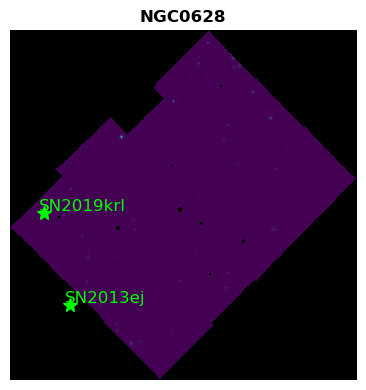

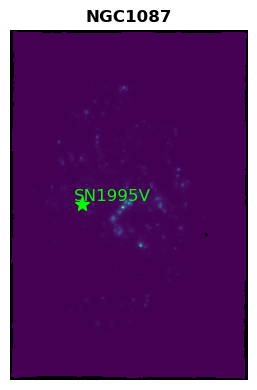

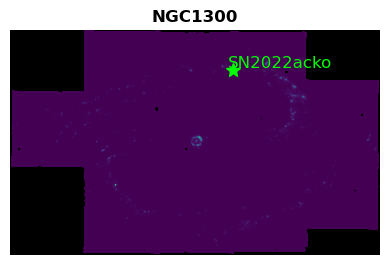

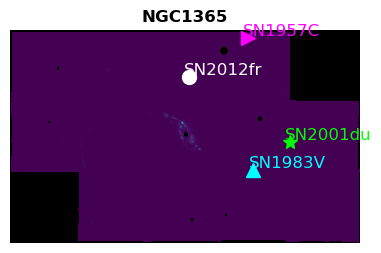

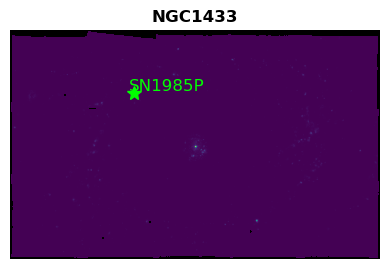

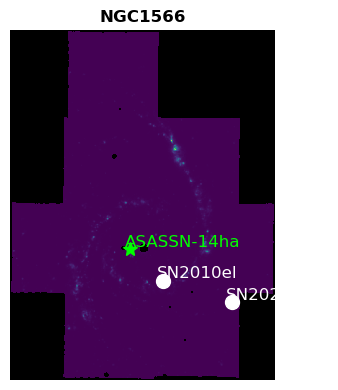

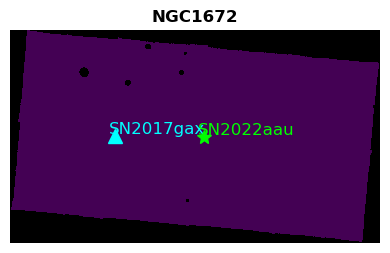

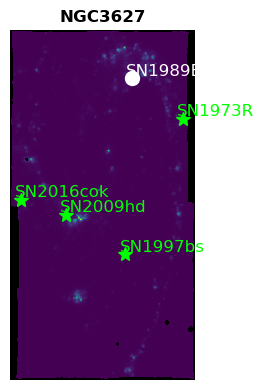

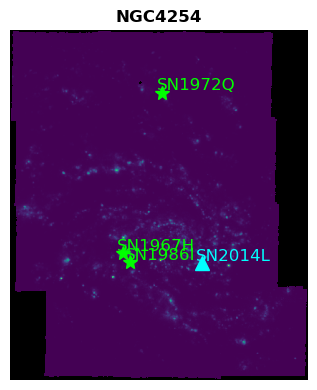

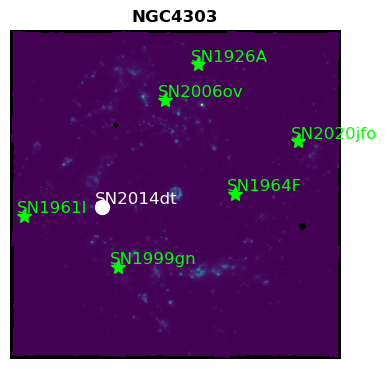

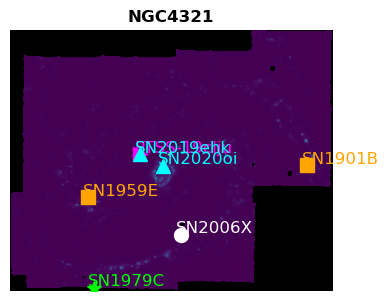

In [3]:
# Build MUSE Catalogue That has all supernovae within PHANGS-MUSE footprint
# exploratory plotting: galaxies with SNe 

gals, sne_names, sne_types, sne_ra, sne_dec = [],[],[],[],[]

for i in range(len(maps_nat)):
    sn_name, sn_type, sn_ra, sn_dec, map, x_coord, y_coord = check_in_image(ras, decs, SNe, types, maps_nat[i], ext=ext)
    
    # plot SNe and add their info that are found within footprint to list
    if len(sn_name) > 0:
        
        plt.figure(figsize=(4, 4))                             # set up plot
        cmap = mpl.colormaps.get_cmap('viridis')  # viridis is the default colormap for imshow
        cmap.set_bad(color='black')
        plt.imshow(map, origin='lower', interpolation='nearest', zorder=1, cmap=cmap)
        
        for j in range(len(sn_name)):                      # get lists of SNe info
            gals.append(galaxies[i])
            sne_names.append(sn_name[j])
            sne_types.append(sn_type[j])
            sne_ra.append(sn_ra[j])
            sne_dec.append(sn_dec[j])  
            
            string = sn_name[j]                            # get rest of plot info

            if (len(sn_type[j])>1):
                if sn_type[j][1] == "I":
                    colorCode = 'lime'
                    mkr = '*'
                elif sn_type[j][1] == "b" or sn_type[j][1] == "c":
                    colorCode = 'cyan'
                    mkr = '^'
                elif sn_type[j][1] == "a":
                    colorCode = 'white'
                    mkr = 'o'
                else:
                    colorCode = 'magenta'
                    mkr = '>'
            else:
                colorCode = 'orange'
                mkr='s'

            plt.plot(x_coord[j], y_coord[j], marker=mkr, ms=10, color=colorCode, zorder=10)
            plt.text(x_coord[j]-20, y_coord[j]+8, string, fontsize=12, color=colorCode)
            
        plt.axis('off')
        plt.title(galaxies[i], fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()
        plt.close()


In [4]:
# filter out undesired OSC entries:
# One is a double counted SN named "PTSS-19clju", any LRNs or LBVs, and any candidates
flags = []

for i in range(len(sne_names)):
    if ("LRN" in sne_types[i] or "LBV" in sne_types[i] or "Candidate" in sne_types[i] or "PTSS-19clju" in 
       sne_names[i] or "Gaia21fml" in sne_names[i] or "Gaia21cum" in sne_names[i] or "SN2013ej" in sne_names[i]
       or "SN1979C" in sne_names[i]):
        flags.append(False)
    else:
        flags.append(True)

# put SN data in table and write to file
results = Table({"Galaxy"  : gals,
                "Supernova": sne_names,
                "Type"     : sne_types,
                "SN_ra"    : sne_ra,
                "SN_dec"   : sne_dec,
                "In_Sample": flags})

# write all objects into all_objects file for latex table
results.write("../Data/1.MUSE_All_Objects.csv", format = "csv", overwrite = True)

# apply mask and write cleaned sample to file
mask = results["In_Sample"] == True
cleanData = results[mask]

cleanData.write("../Data/1.MUSE_SN_Sample.csv", format = "csv", overwrite = True)
cleanData[0:1]


<Table length=1>
 Galaxy Supernova  Type       SN_ra              SN_dec       In_Sample
  str7    str11   str12      float64            float64          bool  
------- --------- ----- ----------------- ------------------- ---------
NGC1087   SN1995V    II 41.61152777777777 -0.4987861111111111      True

In [5]:
# join databases to plot SNe on galaxy maps 
fineRes = Table.read("../Data/0.PHANGSMapFiles.csv", format='csv') 

data = join(Data, fineRes, keys = "Galaxy", join_type = 'inner')


data = join(data, cleanData, keys = "Galaxy", join_type = 'inner')
data[0:10]

<Table length=10>
 Galaxy Distance   Gal_ra  ...       SN_ra               SN_dec       In_Sample
  str8  float64   float64  ...      float64             float64          bool  
------- -------- --------- ... ------------------ ------------------- ---------
NGC1087    15.85  41.60492 ...  41.61152777777777 -0.4987861111111111      True
NGC1300    18.99 49.920815 ...  49.91245833333333  -19.39518888888889      True
NGC1365    19.57  53.40152 ...  53.40057916666666  -36.12676944444445      True
NGC1365    19.57  53.40152 ...         53.3713125 -36.142111111111106      True
NGC1365    19.57  53.40152 ... 53.381876388888884  -36.14859166666667      True
NGC1365    19.57  53.40152 ...  53.38349999999999  -36.11770833333333      True
NGC1433    18.63 55.506195 ...        55.52640625 -47.209987222222225      True
NGC1566    17.69  65.00159 ...            64.9725  -54.94808055555555      True
NGC1566    17.69  65.00159 ...  64.99512499999999  -54.94402777777778      True
NGC1566    17.69  65.00159 ...         65.0058875  -54.93807777777778      True

In [6]:
#Group SN data by galaxy and save to new database

gal_groups = data.group_by('Galaxy')
gals = gal_groups.groups.keys
indices = gal_groups.groups.indices
indices = indices.tolist()

#galaxies info
galaxies, dists, gal_ra, gal_dec, gal_pa, incls, MUSE_res, reff = [],[],[],[],[],[],[],[]

# maps info                          
maps_musedap, maps_nat, maps_150, maps_1kpc, maps_HII, maps_irac = [],[],[],[],[],[] 
maps_fine_co, maps_fine_eco, maps_CO21, maps_eCO21, maps_ext, maps_vdisp, maps_HST = [],[],[],[],[],[],[] 
JWST200, JWST300, JWST335, JWST360, JWST770, JWST1000, JWST1130, JWST2100 = [],[],[],[],[],[],[],[]

# SN info
sn_name, sn_type, sn_ra, sn_dec = [],[],[],[]

for i in range(len(indices)-1):
    
    SNnames, SNtypes, SNras, SNdecs = [],[],[],[]               # columns that may have more than one entry    
    
    dists.append(gal_groups["Distance"][indices[i]])
    gal_ra.append(gal_groups["Gal_ra"][indices[i]])
    gal_dec.append(gal_groups["Gal_dec"][indices[i]])
    gal_pa.append(gal_groups["Pos_ang"][indices[i]])
    incls.append(gal_groups["Incl"][indices[i]])
    reff.append(gal_groups["r_eff"][indices[i]])
    MUSE_res.append(gal_groups["MUSE_nat_res"][indices[i]])

    maps_musedap.append(gal_groups["maps_musedap"][indices[i]])
    maps_nat.append(gal_groups["maps_nat"][indices[i]])
    maps_150 .append(gal_groups["maps_150"][indices[i]])
    maps_1kpc.append(gal_groups["maps_1kpc"][indices[i]])
    maps_HII.append(gal_groups["maps_HII"][indices[i]])
    maps_irac.append(gal_groups["maps_irac"][indices[i]])
    maps_CO21.append(gal_groups["maps_CO21"][indices[i]])
    maps_eCO21.append(gal_groups["maps_eCO21"][indices[i]])
    
    if gal_groups["fineRes"][indices[i]] == "":
        maps_fine_co.append(gal_groups["maps_CO21"][indices[i]])
        maps_fine_eco.append(gal_groups["maps_eCO21"][indices[i]])
    else:
        maps_fine_co.append(gal_groups["maps_CO21"][indices[i]].replace("150",str(gal_groups["fineRes"][indices[i]])))
        maps_fine_eco.append(gal_groups["maps_eCO21"][indices[i]].replace("150",str(gal_groups["fineRes"][indices[i]])))

    maps_ext.append(gal_groups["maps_ext"][indices[i]])
    maps_vdisp.append(gal_groups["maps_vdisp"][indices[i]])
    maps_HST.append(gal_groups["maps_HST"][indices[i]])
    
    JWST200.append(gal_groups["JWST200"][indices[i]])
    JWST300.append(gal_groups["JWST300"][indices[i]])
    JWST335.append(gal_groups["JWST335"][indices[i]])
    JWST360.append(gal_groups["JWST360"][indices[i]])
    JWST770.append(gal_groups["JWST770"][indices[i]])
    JWST1000.append(gal_groups["JWST1000"][indices[i]])
    JWST1130.append(gal_groups["JWST1130"][indices[i]])
    JWST2100.append(gal_groups["JWST2100"][indices[i]])
    
    SNnames.append(gal_groups["Supernova"][indices[i]])
    SNtypes.append(gal_groups["Type"][indices[i]])
    SNras.append(gal_groups["SN_ra"][indices[i]])
    SNdecs.append(gal_groups["SN_dec"][indices[i]])
    j = 1
    
    while(indices[i] + j < indices[i+1]):
        SNnames.append(gal_groups["Supernova"][indices[i]+j])
        SNtypes.append(gal_groups["Type"][indices[i]+j])
        SNras.append(gal_groups["SN_ra"][indices[i]+j])
        SNdecs.append(gal_groups["SN_dec"][indices[i]+j])
        j += 1
    
    if len(SNnames) != 0:
        sn_name.append(SNnames)
        sn_type.append(SNtypes)
        sn_ra.append(SNras)
        sn_dec.append(SNdecs)
        galaxies.append(gals[i][0])
        
grouped_data = pd.DataFrame({"galaxy"     : galaxies,
                           "distance"     : dists,
                           "gal_ra"       : gal_ra,
                           "gal_dec"      : gal_dec,
                           "pos_ang"      : gal_pa,
                           "incl"         : incls,
                           "nat_res"      : MUSE_res,
                           "r_eff"        : reff,
                           "maps_musedap" : maps_musedap,
                           "maps_nat"     : maps_nat,
                           "maps_150"     : maps_150,
                           "maps_1kpc"    : maps_1kpc,
                           "maps_HII"     : maps_HII,
                           "maps_irac"    : maps_irac,
                           "maps_CO21"    : maps_CO21,
                           "maps_eCO21"   : maps_eCO21,  
                           "maps_CO_fine" : maps_fine_co,
                           "maps_eCO_fine": maps_fine_eco,
                           "maps_ext"     : maps_ext,
                           "maps_vdisp"   : maps_vdisp,
                           "maps_HST"     : maps_HST,
                           "JWST200"      : JWST200,
                           "JWST300"      : JWST300,
                           "JWST335"      : JWST335,
                           "JWST360"      : JWST360,
                           "JWST770"      : JWST770,
                           "JWST1000"     : JWST1000,
                           "JWST1130"     : JWST1130,
                           "JWST2100"     : JWST2100,
                           "sn_name"      : sn_name,
                           "sn_type"      : sn_type,
                           "sn_ra"        : sn_ra,
                           "sn_dec"       : sn_dec})


In [7]:
maps_fine_eco

['../../GalaxyFiles/ALMACO2-1/ngc1087_12m+7m+tp_co21_120pc_broad_emom0.fits',
 '../../GalaxyFiles/ALMACO2-1/ngc1300_12m+7m+tp_co21_120pc_broad_emom0.fits',
 '../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_co21_120pc_broad_emom0.fits',
 '../../GalaxyFiles/ALMACO2-1/ngc1433_12m+7m+tp_co21_90pc_broad_emom0.fits',
 '../../GalaxyFiles/ALMACO2-1/ngc1566_12m+7m+tp_co21_120pc_broad_emom0.fits',
 '../../GalaxyFiles/ALMACO2-1/ngc1672_12m+7m+tp_co21_120pc_broad_emom0.fits',
 '../../GalaxyFiles/ALMACO2-1/ngc3627_12m+7m+tp_co21_90pc_broad_emom0.fits',
 '../../GalaxyFiles/ALMACO2-1/ngc4254_12m+7m+tp_co21_150pc_broad_emom0.fits',
 '../../GalaxyFiles/ALMACO2-1/ngc4303_12m+7m+tp_co21_150pc_broad_emom0.fits',
 '../../GalaxyFiles/ALMACO2-1/ngc4321_12m+7m+tp_co21_120pc_broad_emom0.fits']

In [8]:
grouped_data.to_csv("../Data/1.GroupedSampleData.csv")
grouped_data[0:1]


galaxy  distance    gal_ra   gal_dec  pos_ang  incl  nat_res      r_eff  \
0  NGC1087     15.85  41.60492 -0.498717    359.1  42.9     0.92  42.091877   

                                        maps_musedap  \
0  ../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/N...   

                                            maps_nat  ...  \
0  ../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...  ...   

                                             JWST335  \
0  ../../GalaxyFiles/JWSTLargeFiles/ngc1087_nirca...   

                                             JWST360  \
0  ../../GalaxyFiles/JWSTLargeFiles/ngc1087_nirca...   

                                             JWST770  \
0  ../../GalaxyFiles/JWSTLargeFiles/ngc1087_miri_...   

                                            JWST1000  \
0  ../../GalaxyFiles/JWSTLargeFiles/ngc1087_miri_...   

                                            JWST1130  \
0  ../../GalaxyFiles/JWSTLargeFiles/ngc1087_miri_...   

                                            JWST2100    sn_name sn_type  \
0  ../../GalaxyFiles/JWSTLargeFiles/ngc1087_miri_...  [SN1995V]    [II]   

                 sn_ra                 sn_dec  
0  [41.61152777777777]  [-0.4987861111111111]  

[1 rows x 33 columns]

In [9]:

# set up multi panel galaxy + SN plot for paper
SNgals, plots, wcss, legendLabels, HII_regs = [],[],[],[],[]

for i in range(len(galaxies)):
        
    if os.path.isfile(maps_nat[i]):
        SNgals.append(galaxies[i])
        hdu = pyfits.open(maps_nat[i])
        img_map = hdu[ext].data
        plots.append(img_map)
        w = WCS(hdu[ext].header, naxis=2)
        wcss.append(w)
        
        hdu_HII = pyfits.open(maps_HII[i])
        map_HII = hdu_HII[0].data
        HII_regs.append(map_HII)
        
        legendlabel = []
        if len(sn_name[i]) > 1:
            for k in range(len(sn_name[i])):
                if sn_type[i][k] == 'Unclassified':
                    typelabel = sn_name[i][k] + ' '  + sn_type[i][k]
                else:
                    typelabel = sn_name[i][k] + ' Type '  + sn_type[i][k]
                legendlabel.append(typelabel)
        else:
            if types[i][0] == 'Unclassified':
                legendlabel.append(sn_name[i][0] + ' '  + sn_type[i][0]) 
            else:        
                legendlabel.append(sn_name[i][0] + ' Type '  + sn_type[i][0])
        legendLabels.append(legendlabel)
        

In [10]:
# # set up multi panel galaxy + SN plot for paper
# markerShapes = ["o", "s", "*", "D", "X", "H", "v"]
# markerSizes  = [120,120,200,120,120,120,120]

# current_cmap = plt.get_cmap("magma")
# current_cmap.set_bad("white")

# import math
# i,j,m=0,0,0
# PLOTS_PER_ROW = 3
# fig, axs = plt.subplots(math.ceil(len(plots)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(15, 30))

# for q in range(len(plots)):

#     xArr, yArr = wcss[m].wcs_world2pix(sn_ra[m],sn_dec[m],0)
#     logplot = np.log10(plots[q])
#     axs[i][j].imshow(logplot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest")#, vmin=, vmax = )
#     axs[i][j].set_title(SNgals[m].upper(), fontsize=20)
#     axs[i][j].set_xticks([])
#     axs[i][j].set_yticks([])
# #     plt.colorbar(logplot, ax=axs[i][j])    

#     pcm = axs[i][j].pcolormesh(logplot)
#     fig.colorbar(pcm, ax=axs[i][j], shrink=0.6)
    
# #     axs[i][j].contour(HII_regs[q],[-1], colors = ["white"], linestyles = ("-"), zorder = 1)
#     for n in range(len(sn_dec[m])):
#         axs[i][j].scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerSizes[n]+30)
#         axs[i][j].scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], 
#                           edgecolor="black", label = legendLabels[m][n])
#     axs[i][j].legend(loc="best", fontsize=14, handletextpad=0.007)

#     j+=1
#     if j%PLOTS_PER_ROW==0:
#         i+=1
#         j=0
#     m +=1
    
# # fig.subplots_adjust(right=0.8)
# # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# # fig.colorbar(logplot, cax=cbar_ax)

# plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
# plt.show()
# fig.savefig("../Figures/MUSEGalaxies.pdf", dpi=300)
# # fig.savefig("../Figures/MUSEGalaxiesHII.pdf", dpi=300)

   

# print()

In [11]:
# # set up multi panel galaxy + SN plot for paper
# markerShapes = ["o", "s", "*", "D", "X", "H", "v"]
# markerSizes  = [120,120,200,120,120,120,120]

# current_cmap = plt.get_cmap("magma")
# current_cmap.set_bad("white")

# import math
# i,j,m=0,0,0
# PLOTS_PER_ROW = 2
# fig, axs = plt.subplots(math.ceil(len(plots[0:4])/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(15, 10))

# for q in range(0,4):

#     xArr, yArr = wcss[m].wcs_world2pix(sn_ra[m],sn_dec[m],0)
#     logplot = np.log10(plots[q])
#     axs[i][j].imshow(logplot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest")#, vmin=, vmax = )
#     axs[i][j].set_title(SNgals[m].upper(), fontsize=20)
#     axs[i][j].set_xticks([])
#     axs[i][j].set_yticks([])
# #     plt.colorbar(logplot, ax=axs[i][j])    

#     pcm = axs[i][j].pcolormesh(logplot)
#     fig.colorbar(pcm, ax=axs[i][j], shrink=0.6)
    
# #     axs[i][j].contour(HII_regs[q],[-1], colors = ["white"], linestyles = ("-"), zorder = 1)
#     for n in range(len(sn_dec[m])):
#         axs[i][j].scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerSizes[n]+30)
#         axs[i][j].scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], 
#                           edgecolor="black", label = legendLabels[m][n])
#     axs[i][j].legend(loc="best", fontsize=14, handletextpad=0.007)

#     j+=1
#     if j%PLOTS_PER_ROW==0:
#         i+=1
#         j=0
#     m +=1
    
# # fig.subplots_adjust(right=0.8)
# # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# # fig.colorbar(logplot, cax=cbar_ax)

# plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
# plt.show()
# fig.savefig("../Figures/MUSEGalaxies.pdf", dpi=300)
# # fig.savefig("../Figures/MUSEGalaxiesHII.pdf", dpi=300)

   

# print()

/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_14509/3532337310.py:17: RuntimeWarning: divide by zero encountered in log10
  logplot = np.log10(plots[0])
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_14509/3532337310.py:32: RuntimeWarning: divide by zero encountered in log10
  logplot = np.log10(plots[1])
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_14509/3532337310.py:48: RuntimeWarning: divide by zero encountered in log10
  logplot = np.log10(plots[2])
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_14509/3532337310.py:63: RuntimeWarning: divide by zero encountered in log10
  logplot = np.log10(plots[3])
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_14509/3532337310.py:81: RuntimeWarning: divide by zero encountered in log10
  logplot = np.log10(plots[4])
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_14509/3532337310.py:96: RuntimeWarning: divide by zero encountered in log10
  logplot = np.log10(plots[5])


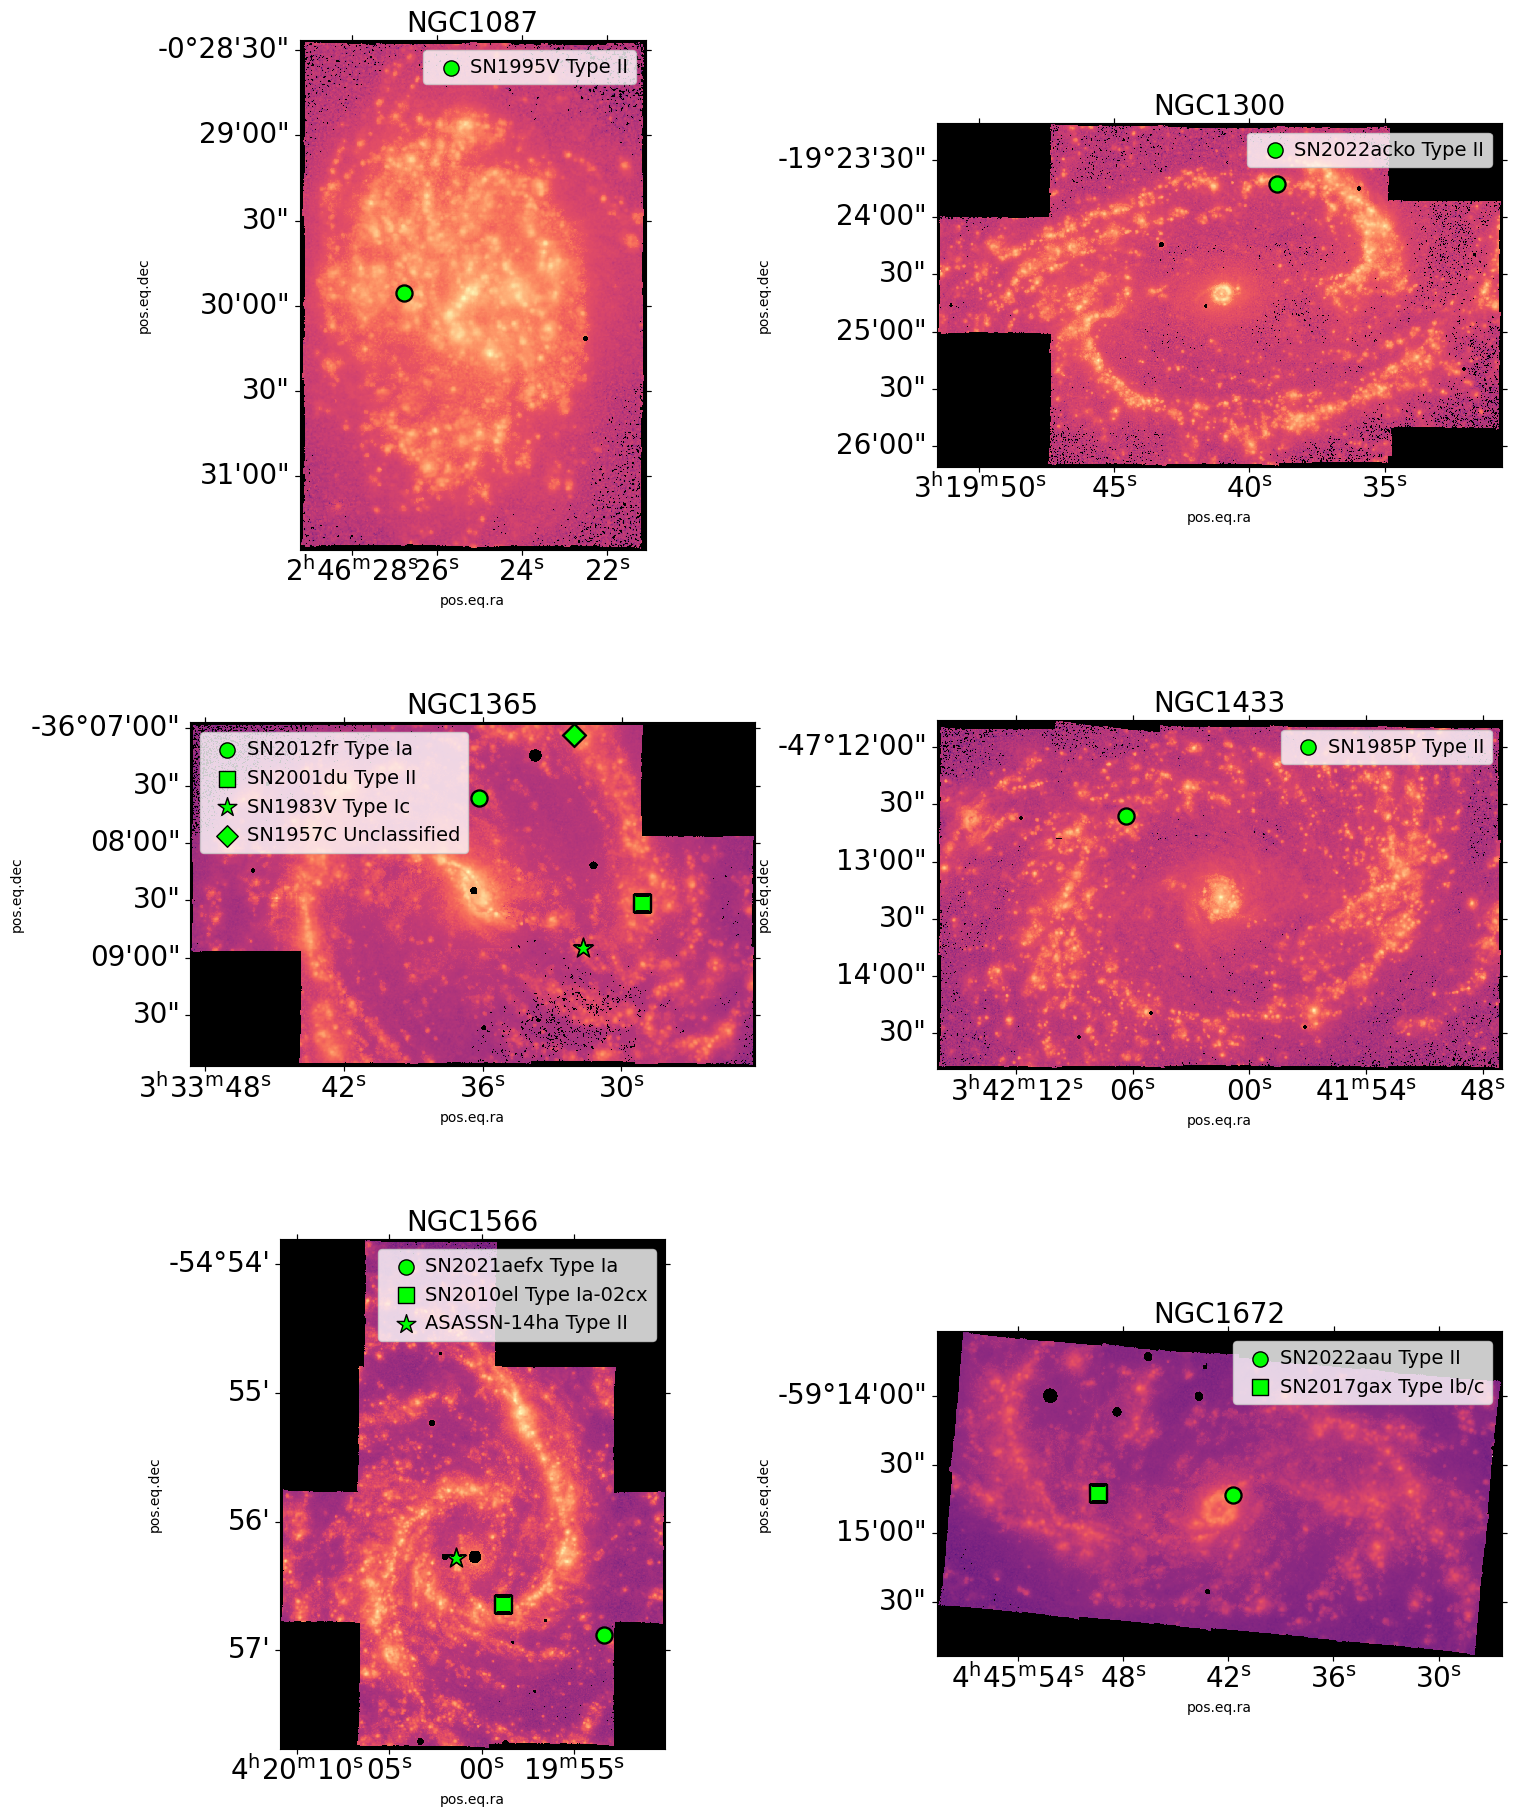

In [12]:
# set up multi panel galaxy + SN plot for paper

# mpl.rc('xtick', labelsize=12) 
# mpl.rc('ytick', labelsize=20) 

markerShapes = ["o", "s", "*", "D", "X", "H", "v"]
markerSizes  = [120,120,200,120,120,120,120]

current_cmap = plt.get_cmap("magma")
current_cmap.set_bad("black")

fig = plt.figure(figsize=(15,18))
ax0 = plt.subplot(3,2,1,projection=wcss[0])


xArr, yArr = wcss[0].wcs_world2pix(sn_ra[0],sn_dec[0],0)
logplot = np.log10(plots[0])

ax0.imshow(logplot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest")
ax0.set_title(SNgals[0].upper(), fontsize=20)
ax0.set_xticks([])
ax0.set_yticks([])

for n in range(len(sn_dec[0])):
    ax0.scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerSizes[n]+30)
    ax0.scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], 
                      edgecolor="black", label = legendLabels[0][n])
ax0.legend(loc="best", fontsize=14, handletextpad=0.007)


xArr, yArr = wcss[1].wcs_world2pix(sn_ra[1],sn_dec[1],0)
logplot = np.log10(plots[1])
ax1 = plt.subplot(3,2,2,projection=wcss[1])

ax1.imshow(logplot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest")#, vmin=, vmax = )
ax1.set_title(SNgals[1].upper(), fontsize=20)
ax1.set_xticks([])
ax1.set_yticks([])

for n in range(len(sn_dec[1])):
    ax1.scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerSizes[n]+30)
    ax1.scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], 
                      edgecolor="black", label = legendLabels[1][n])
ax1.legend(loc="best", fontsize=14, handletextpad=0.007)


xArr, yArr = wcss[2].wcs_world2pix(sn_ra[2],sn_dec[2],0)
logplot = np.log10(plots[2])
ax2 = plt.subplot(3,2,3,projection=wcss[2])


ax2.imshow(logplot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest")#, vmin=, vmax = )
ax2.set_title(SNgals[2].upper(), fontsize=20)

for n in range(len(sn_dec[2])):
    ax2.scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerSizes[n]+30)
    ax2.scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], 
                      edgecolor="black", label = legendLabels[2][n])
ax2.legend(loc="best", fontsize=14, handletextpad=0.007)


xArr, yArr = wcss[3].wcs_world2pix(sn_ra[3],sn_dec[3],0)
logplot = np.log10(plots[3])
ax3 = plt.subplot(3,2,4,projection=wcss[3])


ax3.imshow(logplot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest")#, vmin=, vmax = )
ax3.set_title(SNgals[3].upper(), fontsize=20)
ax3.set_xticks([])
ax3.set_yticks([])

for n in range(len(sn_dec[3])):
    ax3.scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerSizes[n]+30)
    ax3.scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], 
                      edgecolor="black", label = legendLabels[3][n])
ax3.legend(loc="best", fontsize=14, handletextpad=0.007)

ax4 = plt.subplot(3,2,5,projection=wcss[4])

xArr, yArr = wcss[4].wcs_world2pix(sn_ra[4],sn_dec[4],0)
logplot = np.log10(plots[4])

ax4.imshow(logplot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest")#, vmin=, vmax = )
ax4.set_title(SNgals[4].upper(), fontsize=20)
ax4.set_xticks([])
ax4.set_yticks([])

for n in range(len(sn_dec[4])):
    ax4.scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerSizes[n]+30)
    ax4.scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], 
                      edgecolor="black", label = legendLabels[4][n])
ax4.legend(loc="best", fontsize=14, handletextpad=0.007)


xArr, yArr = wcss[5].wcs_world2pix(sn_ra[5],sn_dec[5],0)
logplot = np.log10(plots[5])
ax5 = plt.subplot(3,2,6,projection=wcss[5])

ax5.imshow(logplot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest")#, vmin=, vmax = )
ax5.set_title(SNgals[5].upper(), fontsize=20)
ax5.set_xticks([])
ax5.set_yticks([])

for n in range(len(sn_dec[5])):
    ax5.scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerSizes[n]+30)
    ax5.scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], 
                      edgecolor="black", label = legendLabels[5][n])
ax5.legend(loc="best", fontsize=14, handletextpad=0.007)

plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)

# fig.subplots_adjust(right=0.9)
# cbar_ax = fig.add_axes([0.95, 0.1, 0.015, 0.8])
# mappable = mpl.cm.ScalarMappable(cmap=current_cmap)
# fig.colorbar(mappable, cax=cbar_ax)

plt.show()
fig.savefig("../Figures/MUSEGalaxies1.pdf", dpi=300)



/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_14509/277275192.py:6: RuntimeWarning: divide by zero encountered in log10
  logplot = np.log10(plots[6])
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_14509/277275192.py:21: RuntimeWarning: divide by zero encountered in log10
  logplot = np.log10(plots[7])
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_14509/277275192.py:37: RuntimeWarning: divide by zero encountered in log10
  logplot = np.log10(plots[8])
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_14509/277275192.py:52: RuntimeWarning: divide by zero encountered in log10
  logplot = np.log10(plots[9])


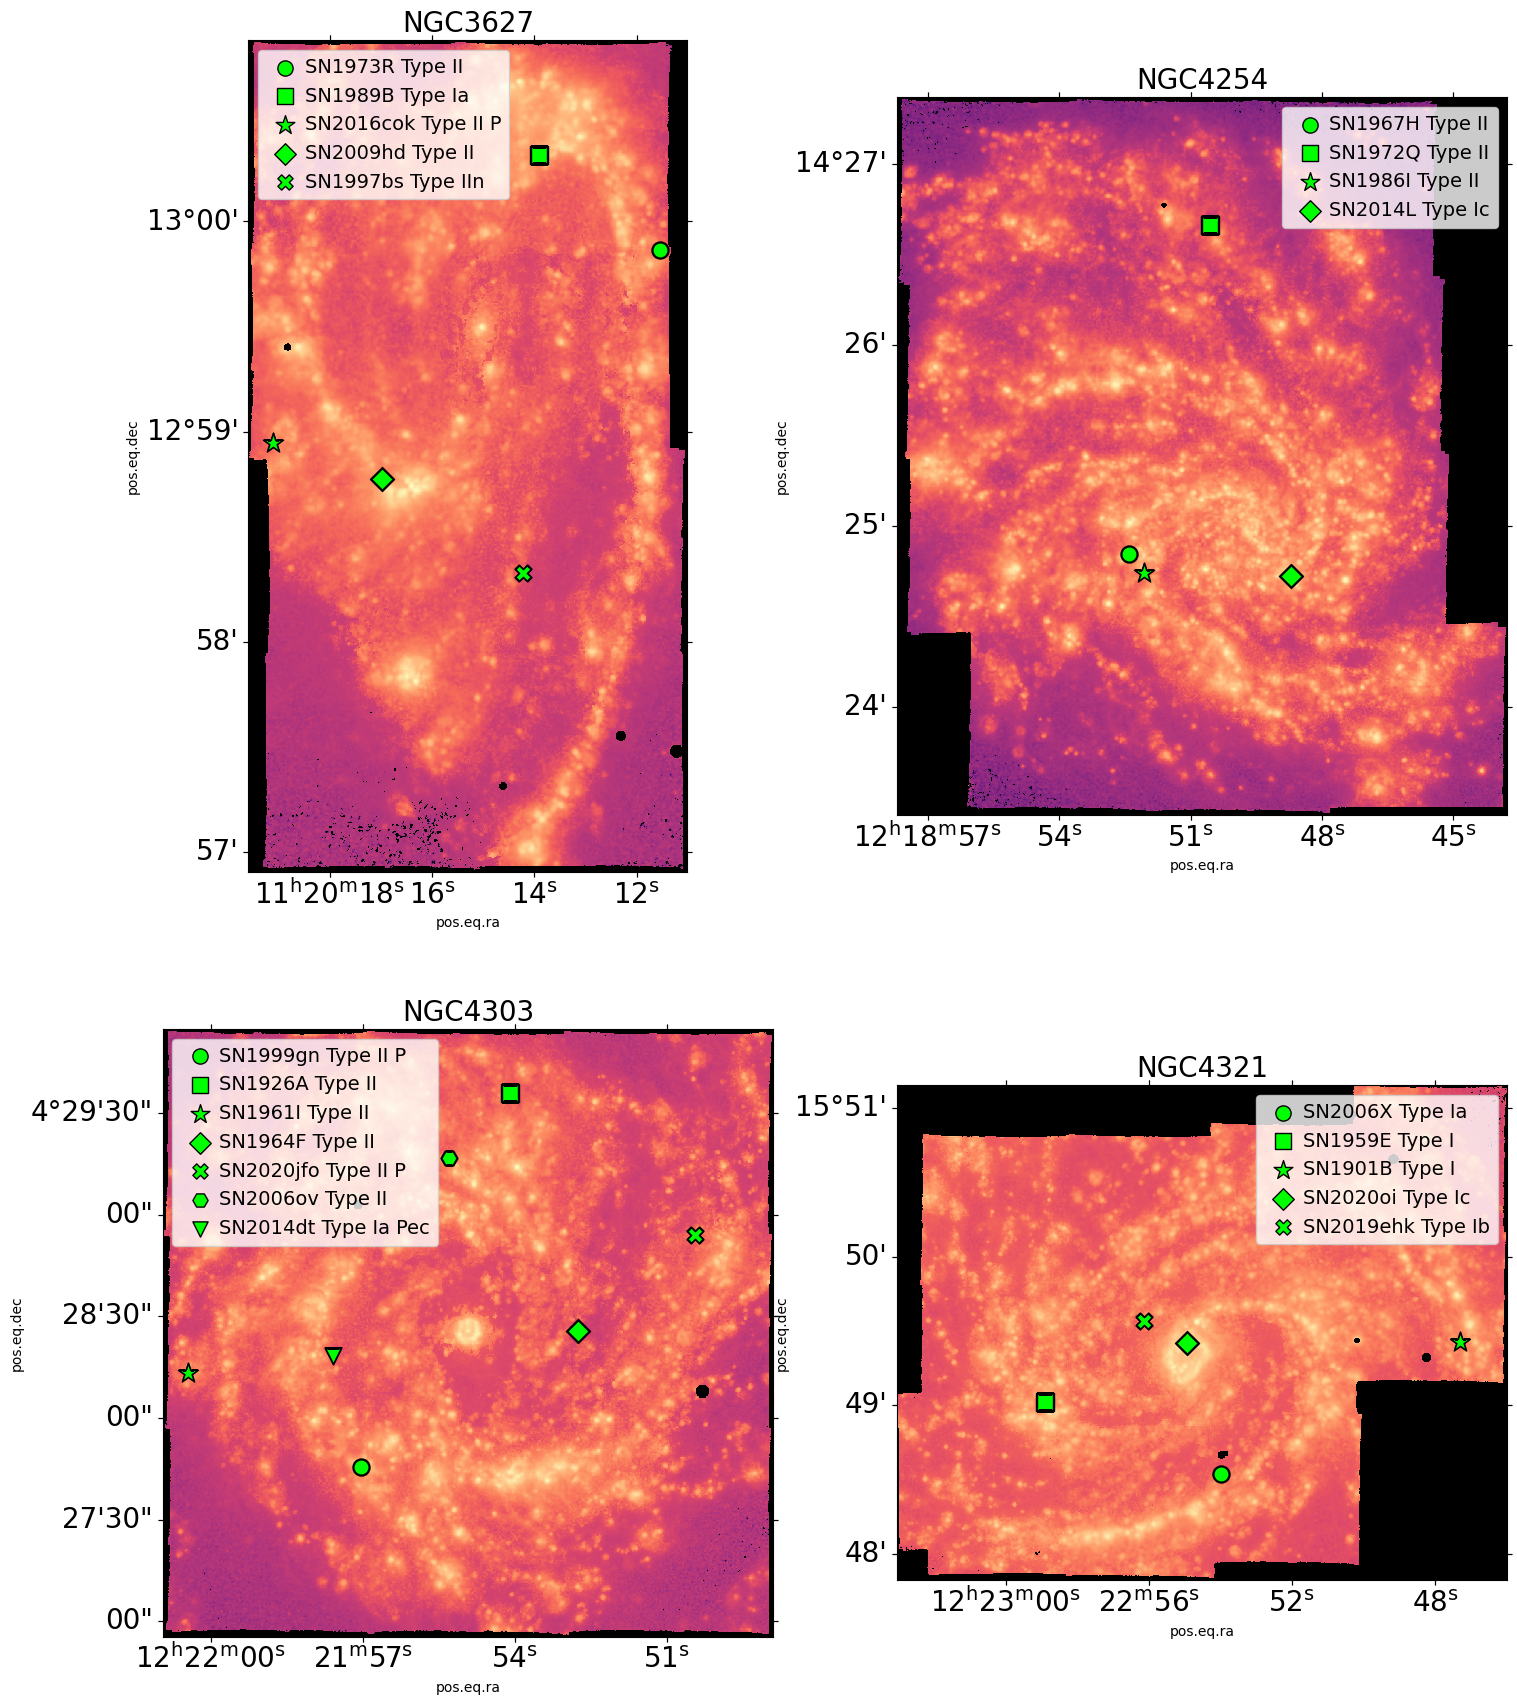

In [13]:

fig = plt.figure(figsize=(15,18))
ax0 = plt.subplot(2,2,1,projection=wcss[6])


xArr, yArr = wcss[6].wcs_world2pix(sn_ra[6],sn_dec[6],0)
logplot = np.log10(plots[6])

ax0.imshow(logplot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest")#, vmin=, vmax = )
ax0.set_title(SNgals[6].upper(), fontsize=20)
ax0.set_xticks([])
ax0.set_yticks([])

for n in range(len(sn_dec[6])):
    ax0.scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerSizes[n]+30)
    ax0.scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], 
                      edgecolor="black", label = legendLabels[6][n])
ax0.legend(loc="best", fontsize=14, handletextpad=0.007)


xArr, yArr = wcss[7].wcs_world2pix(sn_ra[7],sn_dec[7],0)
logplot = np.log10(plots[7])
ax1 = plt.subplot(2,2,2,projection=wcss[7])

ax1.imshow(logplot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest")#, vmin=, vmax = )
ax1.set_title(SNgals[7].upper(), fontsize=20)
ax1.set_xticks([])
ax1.set_yticks([])

for n in range(len(sn_dec[7])):
    ax1.scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerSizes[n]+30)
    ax1.scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], 
                      edgecolor="black", label = legendLabels[7][n])
ax1.legend(loc="best", fontsize=14, handletextpad=0.007)


xArr, yArr = wcss[8].wcs_world2pix(sn_ra[8],sn_dec[8],0)
logplot = np.log10(plots[8])
ax2 = plt.subplot(2,2,3,projection=wcss[8])


ax2.imshow(logplot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest")#, vmin=, vmax = )
ax2.set_title(SNgals[8].upper(), fontsize=20)

for n in range(len(sn_dec[8])):
    ax2.scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerSizes[n]+30)
    ax2.scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], 
                      edgecolor="black", label = legendLabels[8][n])
ax2.legend(loc="best", fontsize=14, handletextpad=0.007)


xArr, yArr = wcss[9].wcs_world2pix(sn_ra[9],sn_dec[9],0)
logplot = np.log10(plots[9])
ax3 = plt.subplot(2,2,4,projection=wcss[9])


ax3.imshow(logplot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest")#, vmin=, vmax = )
ax3.set_title(SNgals[9].upper(), fontsize=20)
ax3.set_xticks([])
ax3.set_yticks([])

for n in range(len(sn_dec[9])):
    ax3.scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerSizes[n]+30)
    ax3.scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], 
                      edgecolor="black", label = legendLabels[9][n])
ax3.legend(loc="best", fontsize=14, handletextpad=0.007)

plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)

plt.show()
fig.savefig("../Figures/MUSEGalaxies2.pdf", dpi=300)



In [14]:
import numpy as np

def gc(gal_ra, gal_dec, incl, pa, sn_ra, sn_dec):
    """
    Calculate deprojected radii and projected angles in a disk.    

    Parameters
    ----------
    gal_ra  : float
        ra coord of the galactic center in degrees
    gal_dec : float
        dec coord of the galactic center in degrees
    incl    : float
        galaxy inclination angle in degrees
    pa      : float
        galaxy position angle in degrees
    sn_ra   : float
        ra coord of the supernova in degrees
    sn_dec  : float
        dec coord of the supernova in degrees
    
    Returns
    -------
    radius_deg : float
        galactocentric radius in degrees
    radius_arcsec : float
        galactocentric radius in arcseconds
    proj_ang : float
        projection angle in degrees (theta in (r,theta))
    """

    # recast the ra and dec arrays in term of the center coordinates
    # arrays are now in degrees from the center
    # offsets in ra and dec on celestial sphere (might misbehave at poles)
    dx_deg = (sn_ra - gal_ra) * np.cos(np.deg2rad(gal_dec))
    dy_deg = sn_dec - gal_dec

    # rotation angle (rotate x-axis up to the major axis)
    rotangle = np.pi/2.0 - np.deg2rad(pa)

    # create deprojected coordinate grids
    # offsets after deprojection with the coordinates we are interested in
    deprojdx_deg = (dx_deg * np.cos(rotangle) +
                    dy_deg * np.sin(rotangle))
    deprojdy_deg = (dy_deg * np.cos(rotangle) -
                    dx_deg * np.sin(rotangle))
    deprojdy_deg /= np.cos(np.deg2rad(incl))

    # make map of deprojected distance from the center
    radius_deg = np.sqrt(deprojdx_deg**2 + deprojdy_deg**2)
    radius_arcsec = radius_deg * 3600
    
    # make map of angle w.r.t. position angle
    projang_deg = np.rad2deg(np.arctan2(deprojdy_deg, deprojdx_deg))

    return radius_deg, radius_arcsec, projang_deg


def gcr(radius_deg, dist):
    """
    Calculates the galactocentric radius of a galaxy
    
    Parameters
    ----------
    radius_deg : float
        radius of the galaxy in degrees
        
    dist       : float
        distance to galaxy in kpc
    """   
            
    value = dist * 1000 *  np.tan(radius_deg)
    return (value)


In [15]:
print("Galaxy. Supernova. Radius [deg]  Radius[arcmin]  Projang [deg]")

for i in range(len(data)):
    
    radius_deg, radius_arcsec, projang_deg = gc(data["Gal_ra"][i], data["Gal_dec"][i], data["Incl"][i], 
                                                data["Pos_ang"][i], data["SN_ra"][i], data["SN_dec"][i])
    print(data["Galaxy"][i], data["Supernova"][i], np.round(radius_arcsec/60.0,2), radius_deg)
    

Galaxy. Supernova. Radius [deg]  Radius[arcmin]  Projang [deg]
NGC1087 SN1995V 0.54 0.009019049623723309
NGC1300 SN2022acko 1.2 0.019962446674440106
NGC1365 SN2012fr 0.95 0.015899099680557274
NGC1365 SN2001du 2.42 0.040354219758907774
NGC1365 SN1983V 1.49 0.02477677669288515
NGC1365 SN1957C 2.49 0.04148071839983639
NGC1433 SN1985P 1.13 0.018838035149122124
NGC1566 SN2021aefx 1.2 0.02002983400982668
NGC1566 SN2010el 0.42 0.00707468002233398
NGC1566 ASASSN-14ha 0.16 0.002732875655171747
NGC1672 SN2022aau 0.15 0.0024532013875256183
NGC1672 SN2017gax 1.11 0.01856467006699165
NGC3627 SN1973R 1.54 0.025683647559334537
NGC3627 SN1989B 0.91 0.015120616988580436
NGC3627 SN2016cok 1.83 0.030573968307027126
NGC3627 SN2009hd 1.05 0.017580687273636757
NGC3627 SN1997bs 1.29 0.021433370772136258
NGC4254 SN1967H 0.73 0.012246597807361627
NGC4254 SN1972Q 1.97 0.03278304185810917
NGC4254 SN1986I 0.71 0.011804585678542293
NGC4254 SN2014L 0.36 0.0060197348713900145
NGC4303 SN1999gn 0.85 0.0141148790352981

In [16]:
#             r = gcr(r_deg, data["distance"][i])
#             reff = r / (data["r_eff"][i])
#             rad.append(r/1000)
#             gcr_reff.append(reff)
#             met.append(reff * data["Slope"][i] + data["Intercept"][i])
            
            
            
rads = [0.95,2.42,1.49,2.49] # deprojected radii in arcminutes
r_eff = 3.3 # reff in arcminutes

slope = -0.188
intercept = 8.666

vals = []
for i in range(len(rads)):
    vals.append(rads[i]/r_eff * slope + intercept)

print(vals)

[8.611878787878789, 8.528133333333333, 8.581115151515151, 8.524145454545454]


/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_14509/2843377722.py:7: RuntimeWarning: divide by zero encountered in log10
  logplot = np.log10(plots[8])


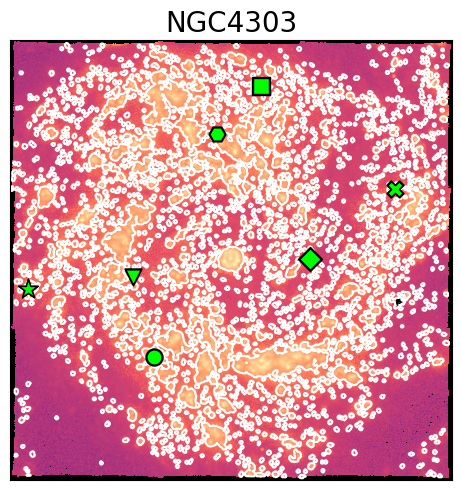

In [17]:

fig = plt.figure(figsize=(5,5))

hii_hdu = pyfits.open("../Data/HII_reg_masks/NGC4303_nebulae_mask_V2.fits")
hii_map = hii_hdu[0].data

xArr, yArr = wcss[8].wcs_world2pix(sn_ra[8],sn_dec[8],0)
logplot = np.log10(plots[8])

plt.imshow(logplot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest")#, vmin=, vmax = )
plt.title(SNgals[8].upper(), fontsize=20)

plt.contour(hii_map, [3,1000000], colors = ["white"], linestyles = ("-"), hatches=['//'], zorder = 1, alpha=1)

for n in range(len(sn_dec[8])):
    plt.scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerSizes[n]+30)
    plt.scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], 
                      edgecolor="black", label = legendLabels[8][n])
    
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()
fig.savefig("../Figures/NGC4303.pdf", dpi=300)

